In [16]:
'''
Title:  offline Trajektorienplanung
Author: Kaufmann Stefan
Date:   22.05.2023
'''

# Requirements

# python 3.10.6

import numpy as np
import matplotlib.pyplot as plt
import libopc as libs  
import casadi as cas

# 1. Erweitertes Elektromechanisches Modell   
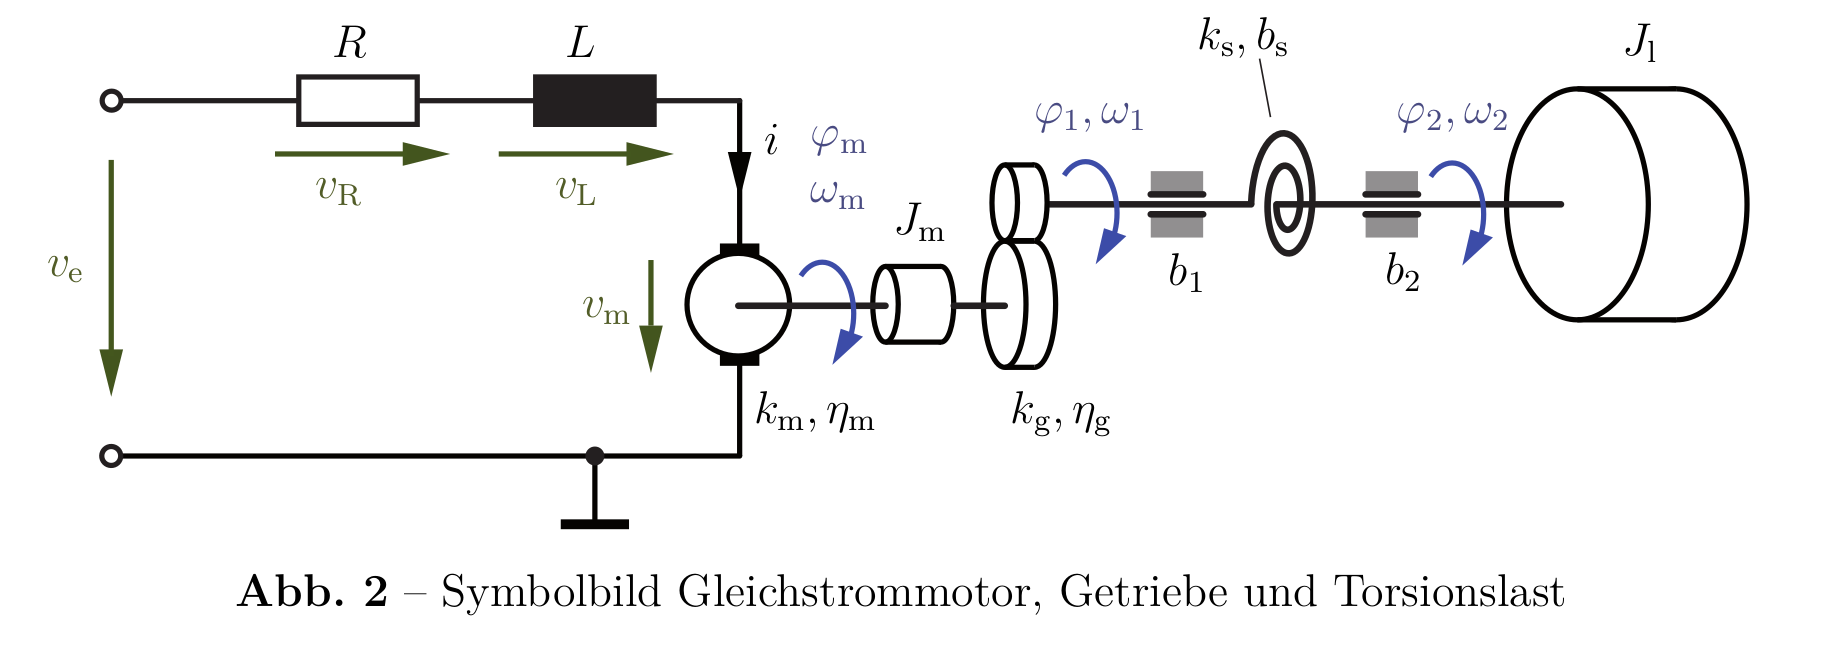

In [17]:
# Gerneral
N = 1000                       # Stützstellen
Tend = 1.3                      # Zeithorizont [s]
t = np.linspace(0,Tend,N+1,endpoint=True)   # Gleichverteilung der Stützstellen --> alternative mit Variablen dt
dt = Tend/N
nx = 5
nu = 1

# Anfangsbedingungen und Endbedingungen

x0 = [0,0,0,0,0] 
xN = np.array([0,0,0,np.pi/2,0])
xf = np.transpose(np.array([xN]))
u0 = [0]

umax =  6
umin = -6


### 1.2.1 Zeitoptimale Trajektorie
$
\underset{u(),x()} {min}     \qquad   J(u,x) = \int_{t_{0}}^{t{f}} 1  dt \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \\
\qquad \qquad  g(x(t_{f}),u(t_{f})) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0
$



In [18]:
topti = cas.casadi.Opti()

# Minimiere x und u
X = topti.variable(nx,N+1) # State vector [i,phi,omega]
U = topti.variable(nu,N+1)   # Control vector [u]
T = topti.variable()       # Final Time

#opti.minimize(T)
dt_T = T/N

# Dynamic Constraints
for k in range(N): # loop over control intervals   
   xnew = libs.runge_kutta_k4(libs.f_ex_dynamic,X[:,k],U[:,k],dt_T)   # Runge-Kutta 4 integration  
   #xnew = X[:,k] + dt_T*libs.f_ex_dynamic(X[:,k],U[:,k])                 # Forwärtsintegration
   topti.subject_to(X[:,k+1] == xnew)



# Boundary Conditions
topti.subject_to(X[:,0] == x0)                        # Anfangsbedingung
topti.subject_to(X[:,N] == xN)          # Endbedingung

#topti.subject_to(U[:,0] == u0)

# ---- misc. constraints  ----------
topti.subject_to(T>0)                               # Time must be positive

# Path constraints

topti.subject_to(topti.bounded(umin,cas.vec(U),umax))

# ---- initial values for solver ---
topti.set_initial(T, 1)

# Cost-function 
topti.minimize(T)         # Zeit


# Initial guess
#topti.set_initial(U[0,:],-0.2) 

# Solver
p_opts = {"expand":True}
s_opts = {"max_iter": 1000}
topti.solver('ipopt', p_opts,s_opts)
sol_T = topti.solve()

X1 = sol_T.value(X)
U1 = sol_T.value(U)
T1 = sol_T.value(T)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    40010
Number of nonzeros in inequality constraint Jacobian.:     1002
Number of nonzeros in Lagrangian Hessian.............:     6001

Total number of variables............................:     6007
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5010
Total number of inequality constraints...............:     1002
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:     1001
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.57e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:997: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

Kosten Zeitoptimal :  13.507322163223117


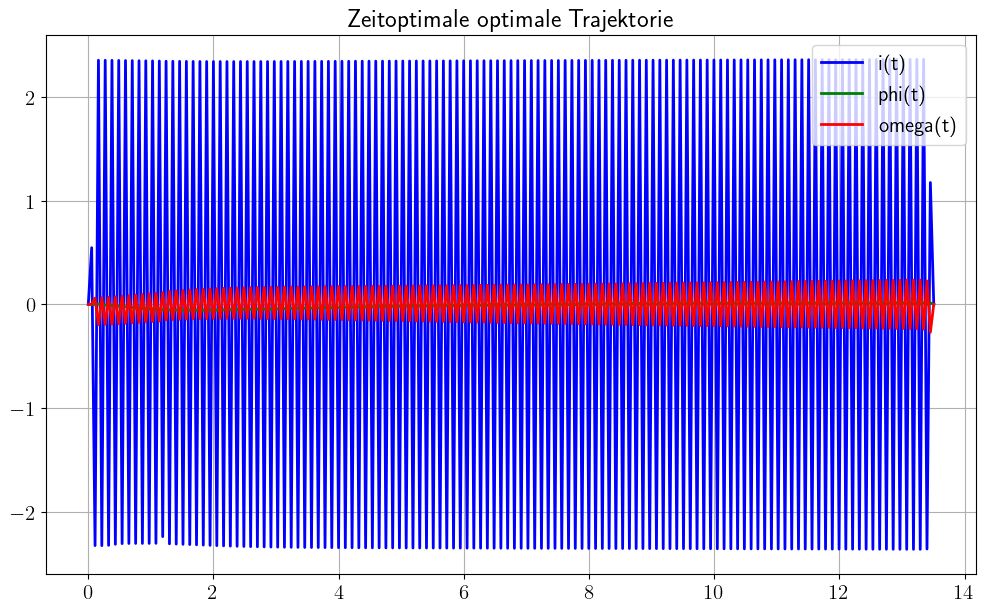

In [ ]:
t1 = t*T1/Tend
print('Kosten Zeitoptimal : ',T1)

plt.figure(figsize=(12,7))
plt.plot(t1,X1[0], 'b', linewidth ='2', label = 'i(t)')
plt.plot(t1,X1[1], 'g', linewidth ='2', label = 'phi(t)')
plt.plot(t1,X1[2], 'r', linewidth ='2', label = 'omega(t)')

plt.grid()
plt.legend(loc = 'best')
plt.title('Zeitoptimale optimale Trajektorie')

plt.show()

### 1.2.2 Energieoptimale Trajektorie
$
\underset{u(),x()} {min}     \qquad   J(u,x) = \int_{t_{0}}^{t{f}} U(t)I(t) dt   \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \\
\qquad \qquad  g(x(t_{f}),u(t_{f})) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0
$

In [ ]:
# Cost function
def cost_Scheinleistung(x,u):
    # x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]    
    # mit x0 = [i, phi, omega]    
    cost = 0
    for k in range(0,N-1):  
        cost += dt*((x[0,k]-xN[0])*u[k])      #  laufende Kosten  U*I*dt        
    
    
    return cost

In [ ]:
opti2 = cas.casadi.Opti()

# Minimiere x und u
X = opti2.variable(nx,N+1) # State vector 
U = opti2.variable(nu,N+1)   # Control vector 

# Dynamic Constraints
for k in range(N): # loop over control intervals   
   xnew = libs.runge_kutta_k4(libs.f_ex_dynamic,X[:,k],U[:,k],dt)   # Runge-Kutta 4 integration  
   #xnew = X[:,k] + dt*libs.f_ex_dynamic(X[:,k],U[:,k])               # Forwärtsintegration
   opti2.subject_to(X[:,k+1] == xnew)

# Boundary Conditions
opti2.subject_to(X[:,0] == x0)          # Anfangsbedingung
opti2.subject_to(X[:,N-2:] == xN)          # Endbedingung

opti2.subject_to(U[:,0] == u0)          # Anfangseingang


# Path constraints
opti2.subject_to(opti2.bounded(umin,cas.vec(U),umax))


# ---- initial values for solver ---
#opti.set_initial(T, 1)


# Cost-function 
opti2.minimize(cost_Scheinleistung(X,U))  # Quadratische Kostenfunktion


# Initial guess
#opti.set_initial(U[0,:],-0.2) 

# Solver
p_opts = {"expand":True}
s_opts = {"max_iter": 1000}
opti2.solver('ipopt', p_opts, s_opts)
sol2 = opti2.solve()

X2 = sol2.value(X)
U2 = sol2.value(U)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     8771
Number of nonzeros in inequality constraint Jacobian.:      251
Number of nonzeros in Lagrangian Hessian.............:      249

Total number of variables............................:     1506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1271
Total number of inequality constraints...............:      251
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      251
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.57e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:997: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

Kosten Scheinleistung :  0.0456738091863853


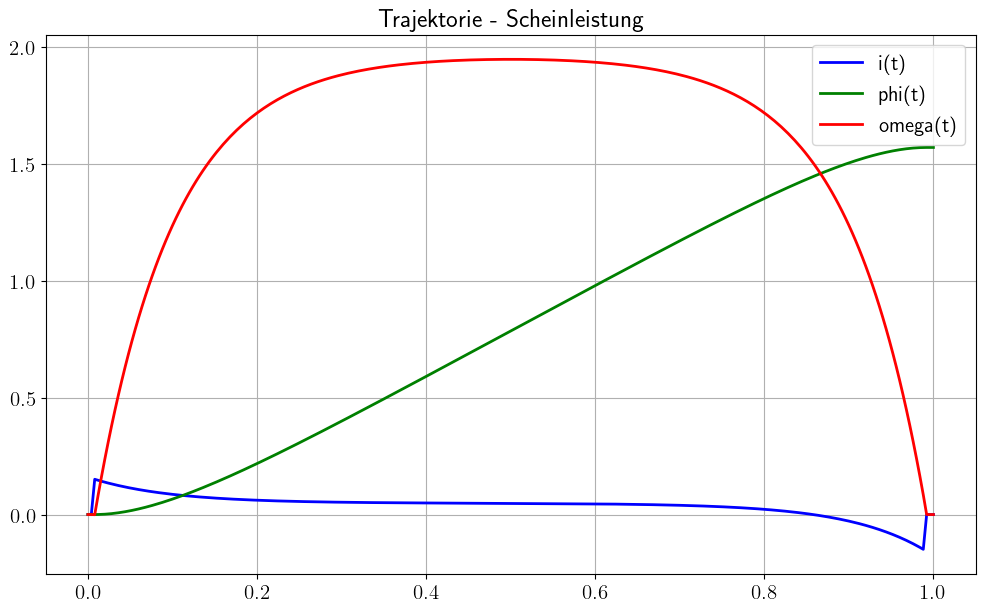

In [ ]:
print('Kosten Scheinleistung : ',cost_Scheinleistung(X2,U2))
plt.figure(figsize=(12,7))
plt.plot(t,X2[0], 'b', linewidth ='2', label = 'i(t)')
plt.plot(t,X2[1], 'g', linewidth ='2', label = 'phi(t)')
plt.plot(t,X2[2], 'r', linewidth ='2', label = 'omega(t)')

plt.grid()
plt.legend(loc = 'best')
plt.title('Trajektorie - Scheinleistung')

plt.show()


### 1.2.3 Quadratisches Gütemaß
$
\underset{u(),x()} {min}     \qquad   J(u,x) = x_{tf}^{T}Sx_{tf} + \int_{t_{0}}^{t{f}} (x^{T}Qx + u^{T}Ru)  dt   \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \\
\qquad \qquad  g(x(t_{f}),u(t_{f})) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0
$

In [ ]:
# Quadratisches Gütemaß
Q = np.diag([0, 20, 0])          # don't turn too sharply
R = np.diag([1])               # keep inputs small

S = np.diag([0, 10, 0])             # get close to final point

In [ ]:
# Cost function

def cost_quad(x,u,manual=False):
    # x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]    
    
    cost = x[:,N].T@S@x[:,N]/2            # Endkostenterm 0.5*xSx
    for k in range(0,N-1):          
        if manual==False:
            cost += dt*((x[:,k].T-xf.T)@Q@(x[:,k]-xf))/2    #  laufende Kosten  1 + 0.5*(xQx + uRu)      
        else:            
            cost += dt*((x[:,k].T-xN)@Q@(x[:,k]-xN))/2 

        cost += dt*u[k]*R*u[k]/2
            
    return cost

In [ ]:
opti3 = cas.casadi.Opti()

# Minimiere x und u
X = opti3.variable(nx,N+1) # State vector 
U = opti3.variable(nu,N+1)   # Control vector 


# Dynamic Constraints
for k in range(N): # loop over control intervals   
   xnew = libs.runge_kutta_k4(libs.f_ex_dynamic,X[:,k],U[:,k],dt)   # Runge-Kutta 4 integration  
   #xnew = X[:,k] + dt*f(X[:,k],U[:,k])              # Forwärtsintegration
   opti3.subject_to(X[:,k+1] == xnew)


# Boundary Conditions
opti3.subject_to(X[:,0] == x0)          # Anfangsbedingung
opti3.subject_to(X[:,N-5:] == xN)          # Endbedingung

opti3.subject_to(U[:,0] == u0)          # Anfangseingang


# Path constraints
opti3.subject_to(opti3.bounded(umin,cas.vec(U),umax))


# ---- initial values for solver ---
#opti3.set_initial(T, 1)


# Cost-function 
opti3.minimize(cost_quad(X,U))  # Quadratische Kostenfunktion


# Initial guess
opti3.set_initial(U[0,:],0.2) 

# Solver
p_opts = {"expand":True}
s_opts = {"max_iter": 1000}
opti3.solver('ipopt', p_opts, s_opts)
sol3 = opti3.solve()

X3 = sol3.value(X)
U3 = sol3.value(U)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3272
Number of nonzeros in inequality constraint Jacobian.:      251
Number of nonzeros in Lagrangian Hessian.............:      499

Total number of variables............................:     1004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      772
Total number of inequality constraints...............:      251
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      251
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4595235e+01 3.32e+04 1.26e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Kosten Quadratisches Gütemasß :  [16.56520917]


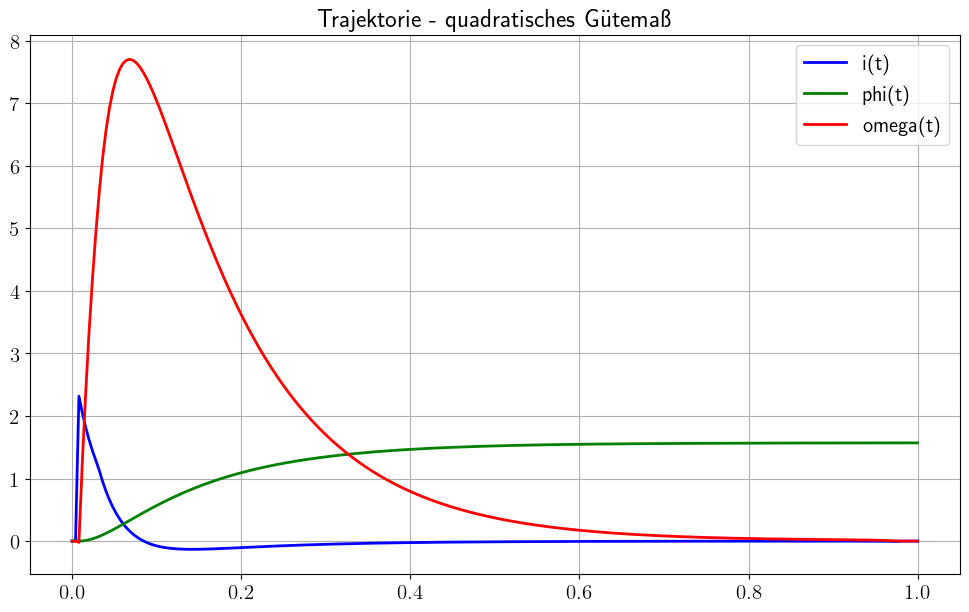

In [ ]:
print('Kosten Quadratisches Gütemasß : ',cost_quad(X3,U3,True).flatten())

plt.figure(figsize=(12,7))
plt.plot(t,X3[0], 'b', linewidth ='2', label = 'i(t)')
plt.plot(t,X3[1], 'g', linewidth ='2', label = 'phi(t)')
plt.plot(t,X3[2], 'r', linewidth ='2', label = 'omega(t)')

plt.grid()
plt.legend(loc = 'best')
plt.title('Trajektorie - quadratisches Gütemaß')

plt.show()

## 1.3 Plots

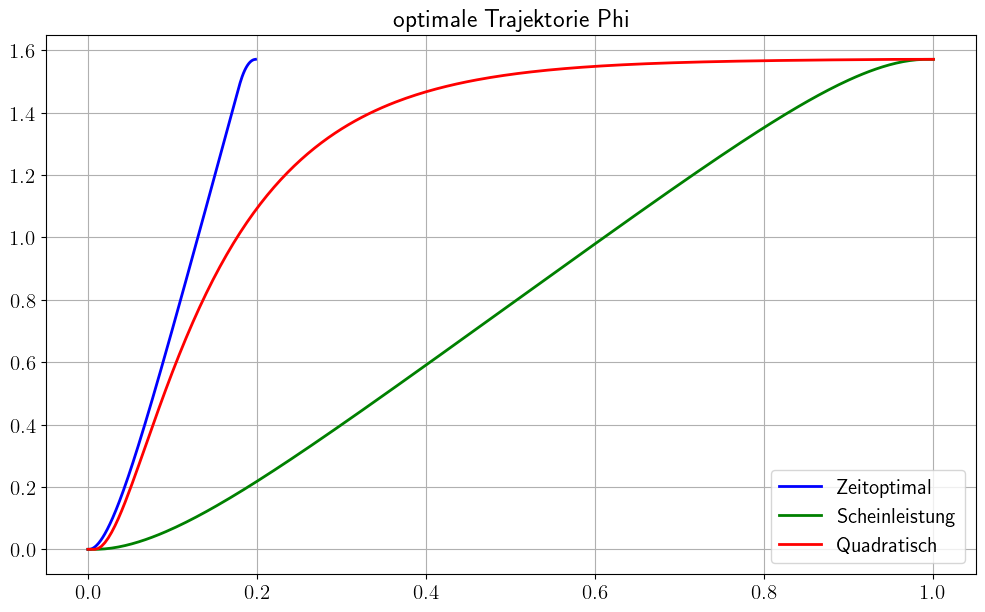

In [ ]:
z = 1
name = ['Strom','Phi','Omega']
plt.figure(figsize=(12,7))
plt.plot(t1,X1[z], 'b', linewidth ='2', label = 'Zeitoptimal')
plt.plot(t,X2[z], 'g', linewidth ='2', label = 'Scheinleistung')
plt.plot(t,X3[z], 'r', linewidth ='2', label = 'Quadratisch')

plt.grid()
plt.legend(loc = 'best')
plt.title('optimale Trajektorie '+name[z])

plt.show()

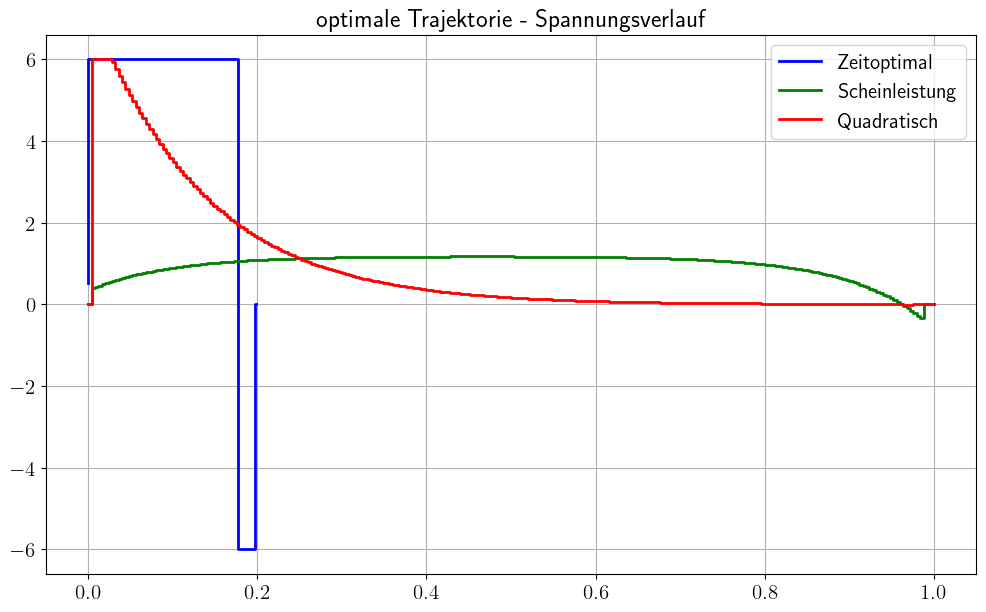

In [ ]:
plt.figure(figsize=(12,7))

plt.step(t1,U1, 'b', linewidth ='2', label = 'Zeitoptimal')
plt.step(t,U2, 'g', linewidth ='2', label = 'Scheinleistung')
plt.step(t,U3, 'r', linewidth ='2', label = 'Quadratisch')


plt.grid()
plt.legend(loc = 'best')
plt.title('optimale Trajektorie - Spannungsverlauf ')

plt.show()

# Überprüfung der Ergebnisse

## Überprüfung mittels Control Toolbox

In [ ]:
import control as ct
import control.optimal as obc


def system_update(t, x, u,params):
    # Return the derivative of the state
    return libs.A_ex@x + libs.B_ex*u

def system_output(t, x, u,params):
    return x



# Define the vehicle steering dynamics as an input/output system
Quanser = ct.NonlinearIOSystem(
    system_update, system_output, states=3, name='Quanser',
    inputs=('u'), outputs=('i','phi','omega'))


Text(0.5, 1.0, 'Eingang')

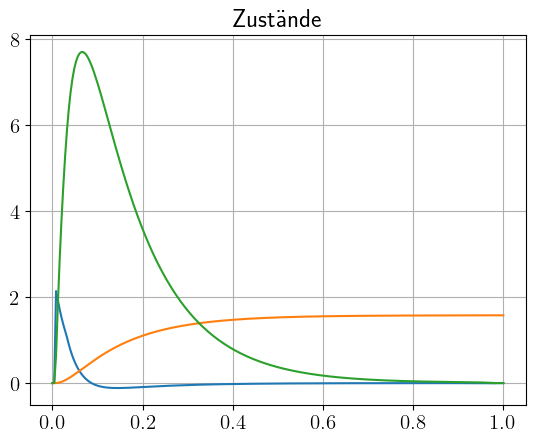

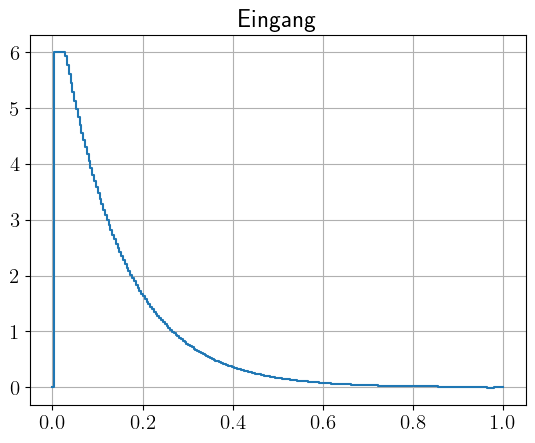

In [ ]:
# Simulate the system dynamics (open loop)
input = U3[:-1] ;  timepts = np.linspace(0, Tend, N, endpoint=True); t_ev=np.linspace(0, Tend, N)
#input = U1[:-1] ;  timepts = np.linspace(0, T1, N, endpoint=True);  t_ev=np.linspace(0, T1, N)

resp = ct.input_output_response(
    Quanser, timepts, input, x0,
    t_eval=t_ev)
t_sim, y_sim, u_sim = resp.time, resp.outputs, resp.inputs


plt.figure(1)
plt.plot(t_sim, y_sim[0])
plt.plot(t_sim, y_sim[1])
plt.plot(t_sim, y_sim[2])
plt.grid()
plt.title('Zustände')

plt.figure(2)
plt.step(t_sim,u_sim[0])
plt.grid()
plt.title('Eingang')


## Export

In [ ]:
# Export mit 1ms
dtexport = 1/1000
libs.exportTrajectForQuanser(X1[1],X1[2],U1,t1,dtexport,'Timeoptimal','2_Daten' )
libs.exportTrajectForQuanser(X2[1],X2[2],U2,t,dtexport,'Scheinleistung','2_Daten' )
libs.exportTrajectForQuanser(X3[1],X3[2],U3,t,dtexport,'Quad','2_Daten' )